In [2]:
import tensorflow as tf
import keras
import cv2
import numpy as np 
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Add, Flatten, Dense, Dropout
from keras.models import Model
# import mnist dataset
from tensorflow.keras.datasets import mnist

from resnet import ResNet18
# load dataset
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
Y_train = Y_train.astype('float32')
Y_test = Y_test.astype('float32')


# set the colormap.
plt.rc("image",cmap="gray")

(28, 28)

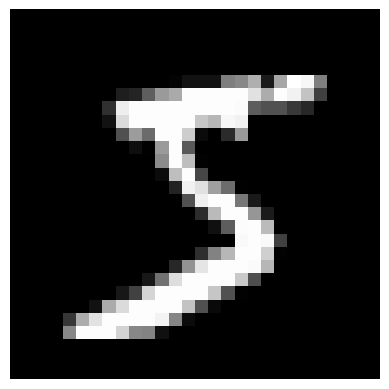

In [3]:
# example image
plt.imshow(tf.squeeze(X_train[0]))
plt.axis("off")

# get the input shape
data_input_shape = X_train[0].shape
data_input_shape

### RESNET-18

In [4]:
earlystop = keras.callbacks.EarlyStopping(
    min_delta=0.01,
    restore_best_weights=True,
    patience=20,
)



In [5]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size = 0.2,shuffle = True)
y_train_encoded = to_categorical(y_train)
y_val_encoded = to_categorical(y_val)

In [6]:
earlystop = keras.callbacks.EarlyStopping(
    min_delta=0.01,
    restore_best_weights=True,
    patience=20,
)

In [7]:
resnet_18 = ResNet18()
resnet_18(tf.zeros([1, 28,28,1]), training = True)
resnet_18.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
resnet_18.summary()

Model: "res_net18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ my_conv2d (MyConv2D)            │ ?                      │         3,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block (ResidualBlock)  │ ?                      │        74,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_1                │ ?                      │        74,368 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_2                │ ?                      │       231,296 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_3                │ ?                      │       296,192 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_4                │ ?                      │       921,344 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_5                │ ?                      │     1,182,208 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_6                │ ?                      │     3,677,696 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_7                │ ?                      │     4,723,712 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,189,770 (42.69 MB)

 Trainable params: 11,180,170 (42.65 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [8]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)
x_train.shape


(48000, 28, 28, 1)

In [9]:
y_train_encoded.shape

(48000, 10)

In [10]:
history = resnet_18.fit(x_train, y_train_encoded, batch_size=1024,epochs=10, validation_data=(x_val, y_val_encoded), callbacks=[earlystop])

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 56s 985ms/step - accuracy: 0.8112 - loss: 0.7963 - val_accuracy: 0.1864 - val_loss: 16.6896
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 45s 967ms/step - accuracy: 0.9855 - loss: 0.0477 - val_accuracy: 0.7446 - val_loss: 1.2841
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 43s 925ms/step - accuracy: 0.9916 - loss: 0.0271 - val_accuracy: 0.9663 - val_loss: 0.1107
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 45s 961ms/step - accuracy: 0.9923 - loss: 0.0224 - val_accuracy: 0.9728 - val_loss: 0.0958
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 45s 949ms/step - accuracy: 0.9938 - loss: 0.0203 - val_accuracy: 0.9875 - val_loss: 0.0478
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 46s 983ms/step - accuracy: 0.9953 - loss: 0.0153 - val_accuracy: 0.9812 - val_loss: 0.0670
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9961 - loss: 0.0121 - val_accuracy: 0.9807 - val_loss: 0.0715
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9960 - loss: 0.0115 - val_accuracy:

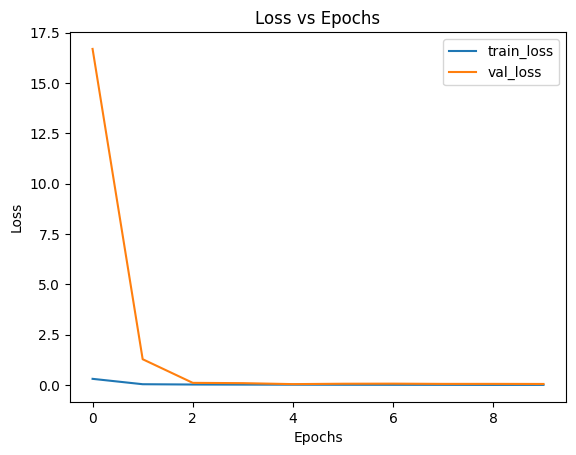

In [13]:
# plot the training history
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [16]:
# test the model
x_test = X_test.reshape(-1, 28, 28, 1)
y_test_encoded = to_categorical(Y_test)
y_pred = resnet_18.predict(x_test)


313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step


Text(0.5, 47.7222222222222, 'Predicted')

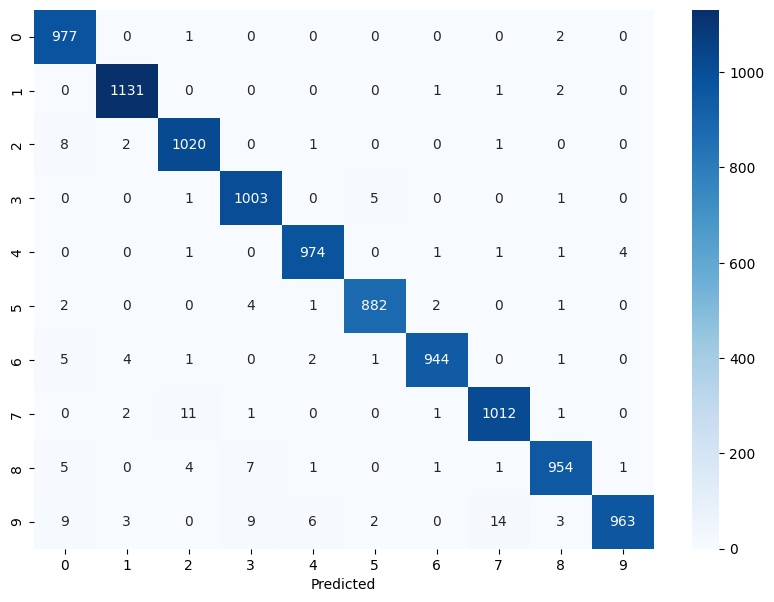

In [18]:

# plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

y_pred = resnet_18.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = Y_test.astype("int")
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm, index=range(10), columns=range(10))
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [19]:
# print accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.986
